In [1]:
!python -V

Python 3.10.11


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment") 
#for creating like headline(?) in mlflow

<Experiment: artifact_location='file:///d:/github/mlops-zoomcamp-course/module-02/mlruns/1', creation_time=1716716457026, experiment_id='1', last_update_time=1716716457026, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.827368941909368

C:\Users\asus\AppData\Local\Temp\ipykernel_8248\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\asus\AppData\Local\Temp\ipykernel_8248\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


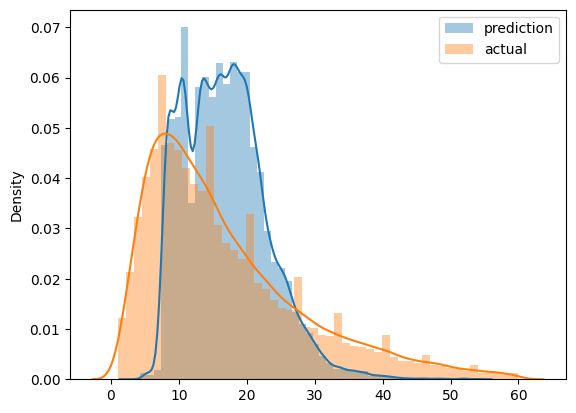

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715203341164

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Using MlFlow

The next one is trying to use mlflow, to tracking the experiment.


In [19]:
with mlflow.start_run():

    #developer tag
    mlflow.set_tag("developer", "Rahma")

    #for parameter (include hyperparameter)
    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", './data/green_tripdata_2021-02.parquet')

    #trying different alpha parameter
    alpha = 0.1
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    #for keeping metric results
    mlflow.log_metric("rmse", rmse)

    #1st way saving model using mlflow
    mlflow.log_artifact(local_path='models/lasso.bin', artifact_path='models_pickle')

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
#Trying using xgboost

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse= mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp (-3), exp(0) -> range
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed':42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.21813                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.13635                           
[2]	validation-rmse:6.86405                           
[3]	validation-rmse:6.77900                           
[4]	validation-rmse:6.74773                           
[5]	validation-rmse:6.73837                           
[6]	validation-rmse:6.73093                           
[7]	validation-rmse:6.72515                           
[8]	validation-rmse:6.71942                           
[9]	validation-rmse:6.71754                           
[10]	validation-rmse:6.71433                          
[11]	validation-rmse:6.70863                          
[12]	validation-rmse:6.70389                          
[13]	validation-rmse:6.70037                          
[14]	validation-rmse:6.69390                          
[15]	validation-rmse:6.69062                          
[16]	validation-rmse:6.67901                          
[17]	validation-rmse:6.67559                          
[18]	validation-rmse:6.67290                          
[19]	valid

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.81589                                                    
[1]	validation-rmse:8.39353                                                    
[2]	validation-rmse:7.58483                                                    
[3]	validation-rmse:7.13474                                                    
[4]	validation-rmse:6.88723                                                    
[5]	validation-rmse:6.74985                                                    
[6]	validation-rmse:6.67002                                                    
[7]	validation-rmse:6.62004                                                    
[8]	validation-rmse:6.58705                                                    
[9]	validation-rmse:6.56664                                                    
[10]	validation-rmse:6.55203                                                   
[11]	validation-rmse:6.54018                                                   
[12]	validation-rmse:6.52952            

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55586                                                   
[1]	validation-rmse:10.97118                                                   
[2]	validation-rmse:10.45257                                                   
[3]	validation-rmse:9.99442                                                    
[4]	validation-rmse:9.58886                                                    
[5]	validation-rmse:9.23494                                                    
[6]	validation-rmse:8.92448                                                    
[7]	validation-rmse:8.65150                                                    
[8]	validation-rmse:8.41325                                                    
[9]	validation-rmse:8.20684                                                    
[10]	validation-rmse:8.02762                                                   
[11]	validation-rmse:7.87132                                                   
[12]	validation-rmse:7.73433            

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85109                                                    
[1]	validation-rmse:7.41820                                                    
[2]	validation-rmse:6.85292                                                    
[3]	validation-rmse:6.62724                                                    
[4]	validation-rmse:6.53668                                                    
[5]	validation-rmse:6.48619                                                    
[6]	validation-rmse:6.45778                                                    
[7]	validation-rmse:6.44184                                                    
[8]	validation-rmse:6.43220                                                    
[9]	validation-rmse:6.42483                                                    
[10]	validation-rmse:6.42060                                                   
[11]	validation-rmse:6.41641                                                   
[12]	validation-rmse:6.41023            

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.29683                                                      
[1]	validation-rmse:7.16196                                                      
[2]	validation-rmse:6.85469                                                      
[3]	validation-rmse:6.76709                                                      
[4]	validation-rmse:6.73046                                                      
[5]	validation-rmse:6.71428                                                      
[6]	validation-rmse:6.70836                                                      
[7]	validation-rmse:6.70588                                                      
[8]	validation-rmse:6.70240                                                      
[9]	validation-rmse:6.69711                                                      
[10]	validation-rmse:6.69476                                                     
[11]	validation-rmse:6.68919                                                     
[12]	validation-

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.67624                                                    
[1]	validation-rmse:8.26320                                                    
[2]	validation-rmse:7.51879                                                    
[3]	validation-rmse:7.13183                                                    
[4]	validation-rmse:6.93186                                                    
[5]	validation-rmse:6.82402                                                    
[6]	validation-rmse:6.75896                                                    
[7]	validation-rmse:6.72059                                                    
[8]	validation-rmse:6.69776                                                    
[9]	validation-rmse:6.67801                                                    
[10]	validation-rmse:6.66426                                                   
[11]	validation-rmse:6.65480                                                   
[12]	validation-rmse:6.64577            

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [15:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.65022                                                     
[1]	validation-rmse:9.48899                                                      
[2]	validation-rmse:8.63940                                                      
[3]	validation-rmse:8.03057                                                      
[4]	validation-rmse:7.59683                                                      
[5]	validation-rmse:7.29054                                                      
[6]	validation-rmse:7.07555                                                      
[7]	validation-rmse:6.91974                                                      
[8]	validation-rmse:6.81124                                                      
[9]	validation-rmse:6.73161                                                      
[10]	validation-rmse:6.67353                                                     
[11]	validation-rmse:6.63064                                                     
[12]	validation-

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.78249                                                      
[1]	validation-rmse:6.90421                                                      
[2]	validation-rmse:6.72210                                                      
[3]	validation-rmse:6.66854                                                      
[4]	validation-rmse:6.64364                                                      
[5]	validation-rmse:6.63349                                                      
[6]	validation-rmse:6.62869                                                      
[7]	validation-rmse:6.62605                                                      
[8]	validation-rmse:6.61835                                                      
[9]	validation-rmse:6.61475                                                      
[10]	validation-rmse:6.61256                                                     
[11]	validation-rmse:6.60897                                                     
[12]	validation-

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.99977                                                   
[1]	validation-rmse:10.02904                                                   
[2]	validation-rmse:9.25943                                                    
[3]	validation-rmse:8.65799                                                    
[4]	validation-rmse:8.18881                                                    
[5]	validation-rmse:7.82897                                                    
[6]	validation-rmse:7.55079                                                    
[7]	validation-rmse:7.33889                                                    
[8]	validation-rmse:7.17448                                                    
[9]	validation-rmse:7.04888                                                    
[10]	validation-rmse:6.95326                                                   
[11]	validation-rmse:6.87943                                                   
[12]	validation-rmse:6.81897            

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.23855                                                     
[1]	validation-rmse:8.90420                                                      
[2]	validation-rmse:8.02791                                                      
[3]	validation-rmse:7.46863                                                      
[4]	validation-rmse:7.11068                                                      
[5]	validation-rmse:6.88496                                                      
[6]	validation-rmse:6.73919                                                      
[7]	validation-rmse:6.64821                                                      
[8]	validation-rmse:6.58456                                                      
[9]	validation-rmse:6.54181                                                      
[10]	validation-rmse:6.50888                                                     
[11]	validation-rmse:6.48747                                                     
[12]	validation-

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.50609                                                        
[1]	validation-rmse:8.09039                                                        
[2]	validation-rmse:7.38918                                                        
[3]	validation-rmse:7.05122                                                        
[4]	validation-rmse:6.88511                                                        
[5]	validation-rmse:6.79349                                                        
[6]	validation-rmse:6.74378                                                        
[7]	validation-rmse:6.71184                                                        
[8]	validation-rmse:6.69167                                                        
[9]	validation-rmse:6.67602                                                        
[10]	validation-rmse:6.66497                                                       
[11]	validation-rmse:6.65918                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.12608                                                       
[1]	validation-rmse:8.78497                                                        
[2]	validation-rmse:7.94786                                                        
[3]	validation-rmse:7.44058                                                        
[4]	validation-rmse:7.13430                                                        
[5]	validation-rmse:6.94926                                                        
[6]	validation-rmse:6.83190                                                        
[7]	validation-rmse:6.75681                                                        
[8]	validation-rmse:6.70991                                                        
[9]	validation-rmse:6.67602                                                        
[10]	validation-rmse:6.65352                                                       
[11]	validation-rmse:6.63675                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78947                                                       
[1]	validation-rmse:11.39384                                                       
[2]	validation-rmse:11.02460                                                       
[3]	validation-rmse:10.68020                                                       
[4]	validation-rmse:10.35945                                                       
[5]	validation-rmse:10.06098                                                       
[6]	validation-rmse:9.78372                                                        
[7]	validation-rmse:9.52627                                                        
[8]	validation-rmse:9.28756                                                        
[9]	validation-rmse:9.06577                                                        
[10]	validation-rmse:8.85996                                                       
[11]	validation-rmse:8.67059                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35308                                                       
[1]	validation-rmse:10.61470                                                       
[2]	validation-rmse:9.98438                                                        
[3]	validation-rmse:9.44681                                                        
[4]	validation-rmse:8.99414                                                        
[5]	validation-rmse:8.61233                                                        
[6]	validation-rmse:8.29149                                                        
[7]	validation-rmse:8.02183                                                        
[8]	validation-rmse:7.79750                                                        
[9]	validation-rmse:7.61070                                                        
[10]	validation-rmse:7.45458                                                       
[11]	validation-rmse:7.32643                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.50629                                                       
[1]	validation-rmse:9.29747                                                        
[2]	validation-rmse:8.45461                                                        
[3]	validation-rmse:7.88257                                                        
[4]	validation-rmse:7.49697                                                        
[5]	validation-rmse:7.23393                                                        
[6]	validation-rmse:7.05851                                                        
[7]	validation-rmse:6.93899                                                        
[8]	validation-rmse:6.85448                                                        
[9]	validation-rmse:6.79611                                                        
[10]	validation-rmse:6.75797                                                       
[11]	validation-rmse:6.73082                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41461                                                        
[1]	validation-rmse:7.15414                                                        
[2]	validation-rmse:6.76324                                                        
[3]	validation-rmse:6.62712                                                        
[4]	validation-rmse:6.56337                                                        
[5]	validation-rmse:6.53518                                                        
[6]	validation-rmse:6.51360                                                        
[7]	validation-rmse:6.50003                                                        
[8]	validation-rmse:6.49270                                                        
[9]	validation-rmse:6.48740                                                        
[10]	validation-rmse:6.48468                                                       
[11]	validation-rmse:6.48118                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.19237                                                       
[1]	validation-rmse:8.86316                                                        
[2]	validation-rmse:8.01477                                                        
[3]	validation-rmse:7.48877                                                        
[4]	validation-rmse:7.16593                                                        
[5]	validation-rmse:6.96772                                                        
[6]	validation-rmse:6.84336                                                        
[7]	validation-rmse:6.76325                                                        
[8]	validation-rmse:6.71225                                                        
[9]	validation-rmse:6.67732                                                        
[10]	validation-rmse:6.65254                                                       
[11]	validation-rmse:6.63527                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98893                                                       
[1]	validation-rmse:10.01607                                                       
[2]	validation-rmse:9.25106                                                        
[3]	validation-rmse:8.65612                                                        
[4]	validation-rmse:8.19721                                                        
[5]	validation-rmse:7.84649                                                        
[6]	validation-rmse:7.57854                                                        
[7]	validation-rmse:7.37468                                                        
[8]	validation-rmse:7.22078                                                        
[9]	validation-rmse:7.10413                                                        
[10]	validation-rmse:7.01546                                                       
[11]	validation-rmse:6.94771                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.54416                                                        
[1]	validation-rmse:8.11770                                                        
[2]	validation-rmse:7.39674                                                        
[3]	validation-rmse:7.04079                                                        
[4]	validation-rmse:6.85762                                                        
[5]	validation-rmse:6.76014                                                        
[6]	validation-rmse:6.70449                                                        
[7]	validation-rmse:6.67125                                                        
[8]	validation-rmse:6.65185                                                        
[9]	validation-rmse:6.63549                                                        
[10]	validation-rmse:6.62425                                                       
[11]	validation-rmse:6.61508                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42689                                                       
[1]	validation-rmse:10.74280                                                       
[2]	validation-rmse:10.15024                                                       
[3]	validation-rmse:9.63903                                                        
[4]	validation-rmse:9.19959                                                        
[5]	validation-rmse:8.82350                                                        
[6]	validation-rmse:8.50313                                                        
[7]	validation-rmse:8.23047                                                        
[8]	validation-rmse:7.99919                                                        
[9]	validation-rmse:7.80285                                                        
[10]	validation-rmse:7.63730                                                       
[11]	validation-rmse:7.49738                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.92005                                                       
[1]	validation-rmse:9.90013                                                        
[2]	validation-rmse:9.10466                                                        
[3]	validation-rmse:8.48631                                                        
[4]	validation-rmse:8.01431                                                        
[5]	validation-rmse:7.65810                                                        
[6]	validation-rmse:7.38293                                                        
[7]	validation-rmse:7.17945                                                        
[8]	validation-rmse:7.02609                                                        
[9]	validation-rmse:6.90705                                                        
[10]	validation-rmse:6.81746                                                       
[11]	validation-rmse:6.74830                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.64192                                                         
[1]	validation-rmse:6.59171                                                         
[2]	validation-rmse:6.57286                                                         
[3]	validation-rmse:6.56475                                                         
[4]	validation-rmse:6.55879                                                         
[5]	validation-rmse:6.54478                                                         
[6]	validation-rmse:6.53418                                                         
[7]	validation-rmse:6.52975                                                         
[8]	validation-rmse:6.52080                                                         
[9]	validation-rmse:6.51146                                                         
[10]	validation-rmse:6.50466                                                        
[11]	validation-rmse:6.49770                                     

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.83153                                                      
[1]	validation-rmse:9.76193                                                       
[2]	validation-rmse:8.94291                                                       
[3]	validation-rmse:8.32311                                                       
[4]	validation-rmse:7.85815                                                       
[5]	validation-rmse:7.51426                                                       
[6]	validation-rmse:7.25962                                                       
[7]	validation-rmse:7.07195                                                       
[8]	validation-rmse:6.93182                                                       
[9]	validation-rmse:6.82853                                                       
[10]	validation-rmse:6.75191                                                      
[11]	validation-rmse:6.69334                                                      
[12]

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78917                                                      
[1]	validation-rmse:11.39486                                                      
[2]	validation-rmse:11.02743                                                      
[3]	validation-rmse:10.68652                                                      
[4]	validation-rmse:10.36821                                                      
[5]	validation-rmse:10.07422                                                      
[6]	validation-rmse:9.80092                                                       
[7]	validation-rmse:9.54801                                                       
[8]	validation-rmse:9.31534                                                       
[9]	validation-rmse:9.09865                                                       
[10]	validation-rmse:8.89879                                                      
[11]	validation-rmse:8.71540                                                      
[12]

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.66522                                                        
[1]	validation-rmse:11.16509                                                        
[2]	validation-rmse:10.70918                                                        
[3]	validation-rmse:10.29344                                                        
[4]	validation-rmse:9.91619                                                         
[5]	validation-rmse:9.57299                                                         
[6]	validation-rmse:9.26294                                                         
[7]	validation-rmse:8.98105                                                         
[8]	validation-rmse:8.72696                                                         
[9]	validation-rmse:8.49878                                                         
[10]	validation-rmse:8.29373                                                        
[11]	validation-rmse:8.11023                                     

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.68322                                                        
[1]	validation-rmse:9.54326                                                         
[2]	validation-rmse:8.70888                                                         
[3]	validation-rmse:8.11648                                                         
[4]	validation-rmse:7.68081                                                         
[5]	validation-rmse:7.37491                                                         
[6]	validation-rmse:7.15885                                                         
[7]	validation-rmse:7.00100                                                         
[8]	validation-rmse:6.89424                                                         
[9]	validation-rmse:6.81531                                                         
[10]	validation-rmse:6.75556                                                        
[11]	validation-rmse:6.70585                                     

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.17903                                                          
[1]	validation-rmse:10.31581                                                          
[2]	validation-rmse:9.60007                                                           
[3]	validation-rmse:9.01105                                                           
[4]	validation-rmse:8.52969                                                           
[5]	validation-rmse:8.13735                                                           
[6]	validation-rmse:7.81966                                                           
[7]	validation-rmse:7.56453                                                           
[8]	validation-rmse:7.36050                                                           
[9]	validation-rmse:7.19651                                                           
[10]	validation-rmse:7.06499                                                          
[11]	validation-rmse:6.95729               

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [16:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60053                                                          
[1]	validation-rmse:11.04689                                                          
[2]	validation-rmse:10.54825                                                          
[3]	validation-rmse:10.10058                                                          
[4]	validation-rmse:9.69822                                                           
[5]	validation-rmse:9.33876                                                           
[6]	validation-rmse:9.01650                                                           
[7]	validation-rmse:8.73048                                                           
[8]	validation-rmse:8.47616                                                           
[9]	validation-rmse:8.24839                                                           
[10]	validation-rmse:8.04779                                                          
[11]	validation-rmse:7.87016               

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:00:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64479                                                         
[1]	validation-rmse:11.12781                                                         
[2]	validation-rmse:10.65838                                                         
[3]	validation-rmse:10.23296                                                         
[4]	validation-rmse:9.84750                                                          
[5]	validation-rmse:9.50001                                                          
[6]	validation-rmse:9.18649                                                          
[7]	validation-rmse:8.90447                                                          
[8]	validation-rmse:8.65069                                                          
[9]	validation-rmse:8.42309                                                          
[10]	validation-rmse:8.21971                                                         
[11]	validation-rmse:8.03762                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65690                                                         
[1]	validation-rmse:11.14957                                                         
[2]	validation-rmse:10.68790                                                         
[3]	validation-rmse:10.26878                                                         
[4]	validation-rmse:9.88801                                                          
[5]	validation-rmse:9.54243                                                          
[6]	validation-rmse:9.23090                                                          
[7]	validation-rmse:8.95058                                                          
[8]	validation-rmse:8.69516                                                          
[9]	validation-rmse:8.46747                                                          
[10]	validation-rmse:8.26321                                                         
[11]	validation-rmse:8.07861                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63896                                                         
[1]	validation-rmse:11.11931                                                         
[2]	validation-rmse:10.64910                                                         
[3]	validation-rmse:10.22466                                                         
[4]	validation-rmse:9.84036                                                          
[5]	validation-rmse:9.49379                                                          
[6]	validation-rmse:9.18451                                                          
[7]	validation-rmse:8.90570                                                          
[8]	validation-rmse:8.65001                                                          
[9]	validation-rmse:8.42714                                                          
[10]	validation-rmse:8.22838                                                         
[11]	validation-rmse:8.04720                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54485                                                         
[1]	validation-rmse:10.94776                                                         
[2]	validation-rmse:10.41583                                                         
[3]	validation-rmse:9.94250                                                          
[4]	validation-rmse:9.52279                                                          
[5]	validation-rmse:9.15183                                                          
[6]	validation-rmse:8.82442                                                          
[7]	validation-rmse:8.53639                                                          
[8]	validation-rmse:8.28350                                                          
[9]	validation-rmse:8.06158                                                          
[10]	validation-rmse:7.86701                                                         
[11]	validation-rmse:7.69741                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73677                                                         
[1]	validation-rmse:11.29641                                                         
[2]	validation-rmse:10.88936                                                         
[3]	validation-rmse:10.51390                                                         
[4]	validation-rmse:10.16796                                                         
[5]	validation-rmse:9.84920                                                          
[6]	validation-rmse:9.55656                                                          
[7]	validation-rmse:9.28802                                                          
[8]	validation-rmse:9.04156                                                          
[9]	validation-rmse:8.81555                                                          
[10]	validation-rmse:8.60871                                                         
[11]	validation-rmse:8.42051                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.24096                                                         
[1]	validation-rmse:10.42251                                                         
[2]	validation-rmse:9.73664                                                          
[3]	validation-rmse:9.16651                                                          
[4]	validation-rmse:8.69333                                                          
[5]	validation-rmse:8.30490                                                          
[6]	validation-rmse:7.98425                                                          
[7]	validation-rmse:7.72340                                                          
[8]	validation-rmse:7.50913                                                          
[9]	validation-rmse:7.33529                                                          
[10]	validation-rmse:7.19403                                                         
[11]	validation-rmse:7.07880                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48207                                                         
[1]	validation-rmse:10.83539                                                         
[2]	validation-rmse:10.26643                                                         
[3]	validation-rmse:9.76608                                                          
[4]	validation-rmse:9.32792                                                          
[5]	validation-rmse:8.94554                                                          
[6]	validation-rmse:8.61248                                                          
[7]	validation-rmse:8.32389                                                          
[8]	validation-rmse:8.07277                                                          
[9]	validation-rmse:7.85679                                                          
[10]	validation-rmse:7.66951                                                         
[11]	validation-rmse:7.50862                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71521                                                         
[1]	validation-rmse:11.25629                                                         
[2]	validation-rmse:10.83382                                                         
[3]	validation-rmse:10.44558                                                         
[4]	validation-rmse:10.08956                                                         
[5]	validation-rmse:9.76363                                                          
[6]	validation-rmse:9.46432                                                          
[7]	validation-rmse:9.19165                                                          
[8]	validation-rmse:8.94177                                                          
[9]	validation-rmse:8.71324                                                          
[10]	validation-rmse:8.50705                                                         
[11]	validation-rmse:8.31806                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.17711                                                         
[1]	validation-rmse:10.31854                                                         
[2]	validation-rmse:9.60967                                                          
[3]	validation-rmse:9.03063                                                          
[4]	validation-rmse:8.56212                                                          
[5]	validation-rmse:8.17845                                                          
[6]	validation-rmse:7.86971                                                          
[7]	validation-rmse:7.62397                                                          
[8]	validation-rmse:7.42785                                                          
[9]	validation-rmse:7.26876                                                          
[10]	validation-rmse:7.14301                                                         
[11]	validation-rmse:7.04080                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.56310                                                         
[1]	validation-rmse:10.98260                                                         
[2]	validation-rmse:10.46245                                                         
[3]	validation-rmse:9.99980                                                          
[4]	validation-rmse:9.58900                                                          
[5]	validation-rmse:9.22647                                                          
[6]	validation-rmse:8.90637                                                          
[7]	validation-rmse:8.62040                                                          
[8]	validation-rmse:8.37006                                                          
[9]	validation-rmse:8.15404                                                          
[10]	validation-rmse:7.96022                                                         
[11]	validation-rmse:7.79544                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76728                                                         
[1]	validation-rmse:11.35478                                                         
[2]	validation-rmse:10.97290                                                         
[3]	validation-rmse:10.61956                                                         
[4]	validation-rmse:10.29456                                                         
[5]	validation-rmse:9.99467                                                          
[6]	validation-rmse:9.71775                                                          
[7]	validation-rmse:9.46452                                                          
[8]	validation-rmse:9.23074                                                          
[9]	validation-rmse:9.01711                                                          
[10]	validation-rmse:8.82141                                                         
[11]	validation-rmse:8.64242                          

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10495                                                        
[1]	validation-rmse:6.67200                                                        
[2]	validation-rmse:6.60707                                                        
[3]	validation-rmse:6.59930                                                        
[4]	validation-rmse:6.58750                                                        
[5]	validation-rmse:6.58387                                                        
[6]	validation-rmse:6.57362                                                        
[7]	validation-rmse:6.56910                                                        
[8]	validation-rmse:6.56282                                                        
[9]	validation-rmse:6.55776                                                        
[10]	validation-rmse:6.54594                                                       
[11]	validation-rmse:6.53912                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44666                                                       
[1]	validation-rmse:10.77451                                                       
[2]	validation-rmse:10.18727                                                       
[3]	validation-rmse:9.67591                                                        
[4]	validation-rmse:9.23214                                                        
[5]	validation-rmse:8.84833                                                        
[6]	validation-rmse:8.51869                                                        
[7]	validation-rmse:8.23549                                                        
[8]	validation-rmse:7.99188                                                        
[9]	validation-rmse:7.78292                                                        
[10]	validation-rmse:7.60431                                                       
[11]	validation-rmse:7.45267                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80553                                                       
[1]	validation-rmse:11.42380                                                       
[2]	validation-rmse:11.06699                                                       
[3]	validation-rmse:10.73367                                                       
[4]	validation-rmse:10.42261                                                       
[5]	validation-rmse:10.13245                                                       
[6]	validation-rmse:9.86243                                                        
[7]	validation-rmse:9.61061                                                        
[8]	validation-rmse:9.37646                                                        
[9]	validation-rmse:9.15929                                                        
[10]	validation-rmse:8.95717                                                       
[11]	validation-rmse:8.77042                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.37806                                                       
[1]	validation-rmse:10.65819                                                       
[2]	validation-rmse:10.04039                                                       
[3]	validation-rmse:9.51113                                                        
[4]	validation-rmse:9.06312                                                        
[5]	validation-rmse:8.68305                                                        
[6]	validation-rmse:8.36157                                                        
[7]	validation-rmse:8.09038                                                        
[8]	validation-rmse:7.86399                                                        
[9]	validation-rmse:7.67281                                                        
[10]	validation-rmse:7.51388                                                       
[11]	validation-rmse:7.38004                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60791                                                       
[1]	validation-rmse:11.06465                                                       
[2]	validation-rmse:10.57369                                                       
[3]	validation-rmse:10.13379                                                       
[4]	validation-rmse:9.73696                                                        
[5]	validation-rmse:9.38285                                                        
[6]	validation-rmse:9.06621                                                        
[7]	validation-rmse:8.78087                                                        
[8]	validation-rmse:8.53065                                                        
[9]	validation-rmse:8.30173                                                        
[10]	validation-rmse:8.10813                                                       
[11]	validation-rmse:7.93237                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.18491                                                       
[1]	validation-rmse:10.32849                                                       
[2]	validation-rmse:9.62106                                                        
[3]	validation-rmse:9.03952                                                        
[4]	validation-rmse:8.56632                                                        
[5]	validation-rmse:8.18482                                                        
[6]	validation-rmse:7.87363                                                        
[7]	validation-rmse:7.62490                                                        
[8]	validation-rmse:7.42241                                                        
[9]	validation-rmse:7.26199                                                        
[10]	validation-rmse:7.13008                                                       
[11]	validation-rmse:7.02689                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.56163                                                       
[1]	validation-rmse:9.35784                                                        
[2]	validation-rmse:8.49294                                                        
[3]	validation-rmse:7.89022                                                        
[4]	validation-rmse:7.46820                                                        
[5]	validation-rmse:7.17906                                                        
[6]	validation-rmse:6.98140                                                        
[7]	validation-rmse:6.84000                                                        
[8]	validation-rmse:6.74391                                                        
[9]	validation-rmse:6.67476                                                        
[10]	validation-rmse:6.62381                                                       
[11]	validation-rmse:6.58549                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.12763                                                        
[1]	validation-rmse:7.72351                                                        
[2]	validation-rmse:7.10540                                                        
[3]	validation-rmse:6.82533                                                        
[4]	validation-rmse:6.70290                                                        
[5]	validation-rmse:6.64232                                                        
[6]	validation-rmse:6.60710                                                        
[7]	validation-rmse:6.58671                                                        
[8]	validation-rmse:6.57475                                                        
[9]	validation-rmse:6.56566                                                        
[10]	validation-rmse:6.56025                                                       
[11]	validation-rmse:6.55618                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08708                                                       
[1]	validation-rmse:10.16995                                                       
[2]	validation-rmse:9.42900                                                        
[3]	validation-rmse:8.83461                                                        
[4]	validation-rmse:8.36203                                                        
[5]	validation-rmse:7.99057                                                        
[6]	validation-rmse:7.69787                                                        
[7]	validation-rmse:7.46874                                                        
[8]	validation-rmse:7.29039                                                        
[9]	validation-rmse:7.15085                                                        
[10]	validation-rmse:7.03892                                                       
[11]	validation-rmse:6.95024                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.86241                                                        
[1]	validation-rmse:8.46363                                                        
[2]	validation-rmse:7.66588                                                        
[3]	validation-rmse:7.21435                                                        
[4]	validation-rmse:6.97164                                                        
[5]	validation-rmse:6.82080                                                        
[6]	validation-rmse:6.73666                                                        
[7]	validation-rmse:6.68066                                                        
[8]	validation-rmse:6.64605                                                        
[9]	validation-rmse:6.62522                                                        
[10]	validation-rmse:6.60856                                                       
[11]	validation-rmse:6.59646                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [18:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.30321                                                       
[1]	validation-rmse:10.52847                                                       
[2]	validation-rmse:9.87275                                                        
[3]	validation-rmse:9.32064                                                        
[4]	validation-rmse:8.86016                                                        
[5]	validation-rmse:8.47429                                                        
[6]	validation-rmse:8.15086                                                        
[7]	validation-rmse:7.88677                                                        
[8]	validation-rmse:7.66404                                                        
[9]	validation-rmse:7.48488                                                        
[10]	validation-rmse:7.33777                                                       
[11]	validation-rmse:7.21009                                                

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [25]:
# training with the best parameter

params = {
    'learning_rate':0.07523708773342407,
    'max_depth':54,
    'min_child_weight':1.7374077524302216,
    'objective':'reg:linear',
    'reg_alpha':0.06190732224719006,
    'reg_lambda':0.24401497467762412,
    'seed':42
}

#will use autolog for xgboost

mlflow.xgboost.autolog(params)
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100, #i change to 100 to get fast result
            evals=[(valid, "validation")],
            early_stopping_rounds = 50
        )

2024/05/27 19:44:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86f4c277d6f84e828b078de7f516b87a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [19:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.60053
[1]	validation-rmse:11.04689
[2]	validation-rmse:10.54825
[3]	validation-rmse:10.10058
[4]	validation-rmse:9.69822
[5]	validation-rmse:9.33876
[6]	validation-rmse:9.01650
[7]	validation-rmse:8.73048
[8]	validation-rmse:8.47616
[9]	validation-rmse:8.24839
[10]	validation-rmse:8.04779
[11]	validation-rmse:7.87016
[12]	validation-rmse:7.71376
[13]	validation-rmse:7.57583
[14]	validation-rmse:7.45166
[15]	validation-rmse:7.34373
[16]	validation-rmse:7.24738
[17]	validation-rmse:7.16244
[18]	validation-rmse:7.08797
[19]	validation-rmse:7.02213
[20]	validation-rmse:6.96308
[21]	validation-rmse:6.91162
[22]	validation-rmse:6.86550
[23]	validation-rmse:6.82400
[24]	validation-rmse:6.78881
[25]	validation-rmse:6.75617
[26]	validation-rmse:6.72751
[27]	validation-rmse:6.70202
[28]	validation-rmse:6.67921
[29]	validation-rmse:6.65900
[30]	validation-rmse:6.64011
[31]	validation-rmse:6.62354
[32]	validation-rmse:6.60790
[33]	validation-rmse:6.59431
[34]	validation-rmse

2024/05/27 19:46:05 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\mlflow\xgboost\__init__.py", line 672, in train_impl
    imp = model.get_score(importance_type=imp_type)
  File "c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py", line 2785, in get_score
    _check_call(
  File "c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [19:46:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.h:266: Unknown feature importance type, expected one of: {"weight", "total_gain", "total_cover", "gain", "cover"}, got: learning_rate
2024/05/27 19:46:06 ERROR mlflow.x

In [26]:
mlflow.xgboost.autolog(disable=True)

In [27]:
#2nd way of saving the model using mlflow

with mlflow.start_run():
    best_params = {
    'learning_rate':0.07523708773342407,
    'max_depth':54,
    'min_child_weight':1.7374077524302216,
    'objective':'reg:linear',
    'reg_alpha':0.06190732224719006,
    'reg_lambda':0.24401497467762412,
    'seed':42
}


    mlflow.log_params(best_params)
    booster = xgb.train(
                    params=params,
                    dtrain=train,
                    num_boost_round=1000,
                    evals=[(valid, "validation")],
                    early_stopping_rounds = 50
                )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

        #log the model
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.60053
[1]	validation-rmse:11.04689
[2]	validation-rmse:10.54825
[3]	validation-rmse:10.10058
[4]	validation-rmse:9.69822
[5]	validation-rmse:9.33876
[6]	validation-rmse:9.01650
[7]	validation-rmse:8.73048
[8]	validation-rmse:8.47616
[9]	validation-rmse:8.24839
[10]	validation-rmse:8.04779
[11]	validation-rmse:7.87016
[12]	validation-rmse:7.71376
[13]	validation-rmse:7.57583
[14]	validation-rmse:7.45166
[15]	validation-rmse:7.34373
[16]	validation-rmse:7.24738
[17]	validation-rmse:7.16244
[18]	validation-rmse:7.08797
[19]	validation-rmse:7.02213
[20]	validation-rmse:6.96308
[21]	validation-rmse:6.91162
[22]	validation-rmse:6.86550
[23]	validation-rmse:6.82400
[24]	validation-rmse:6.78881
[25]	validation-rmse:6.75617
[26]	validation-rmse:6.72751
[27]	validation-rmse:6.70202
[28]	validation-rmse:6.67921
[29]	validation-rmse:6.65900
[30]	validation-rmse:6.64011
[31]	validation-rmse:6.62354
[32]	validation-rmse:6.60790
[33]	validation-rmse:6.59431
[34]	validation-rmse

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [19:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or 

In [28]:
#trying to save the preprocess data 

with mlflow.start_run():

    train = xgb.DMatrix(X_train, label = y_train)
    valid = xgb.DMatrix(X_val, label = y_val)

    best_params = {
    'learning_rate':0.07523708773342407,
    'max_depth':54,
    'min_child_weight':1.7374077524302216,
    'objective':'reg:linear',
    'reg_alpha':0.06190732224719006,
    'reg_lambda':0.24401497467762412,
    'seed':42
}


    mlflow.log_params(best_params)
    booster = xgb.train(
                    params=params,
                    dtrain=train,
                    num_boost_round=1000,
                    evals=[(valid, "validation")],
                    early_stopping_rounds = 50
                )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    #save the preprocessor
    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    #log the model
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [20:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.60053
[1]	validation-rmse:11.04689
[2]	validation-rmse:10.54825
[3]	validation-rmse:10.10058
[4]	validation-rmse:9.69822
[5]	validation-rmse:9.33876
[6]	validation-rmse:9.01650
[7]	validation-rmse:8.73048
[8]	validation-rmse:8.47616
[9]	validation-rmse:8.24839
[10]	validation-rmse:8.04779
[11]	validation-rmse:7.87016
[12]	validation-rmse:7.71376
[13]	validation-rmse:7.57583
[14]	validation-rmse:7.45166
[15]	validation-rmse:7.34373
[16]	validation-rmse:7.24738
[17]	validation-rmse:7.16244
[18]	validation-rmse:7.08797
[19]	validation-rmse:7.02213
[20]	validation-rmse:6.96308
[21]	validation-rmse:6.91162
[22]	validation-rmse:6.86550
[23]	validation-rmse:6.82400
[24]	validation-rmse:6.78881
[25]	validation-rmse:6.75617
[26]	validation-rmse:6.72751
[27]	validation-rmse:6.70202
[28]	validation-rmse:6.67921
[29]	validation-rmse:6.65900
[30]	validation-rmse:6.64011
[31]	validation-rmse:6.62354
[32]	validation-rmse:6.60790
[33]	validation-rmse:6.59431
[34]	validation-rmse

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [20:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or 

make prediction with mlflow, load model with mlflow

In [29]:
logged_model = 'runs:/ddb9659bd80a464c8eade76b1a60450d/models_mlflow'

# load model as a PyFuncModel. (python function)
loaded_model = mlflow.pyfunc.load_model(logged_model)

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [20:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [30]:
#load model with xgboost version

xgboost_model = mlflow.xgboost.load_model(logged_model)

c:\Users\asus\.virtualenvs\module-02-jXzagZlw\lib\site-packages\xgboost\core.py:160: UserWarning: [20:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [31]:
xgboost_model

In [32]:
#start making prediction

y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([14.198157 ,  6.8589253, 14.894394 , 24.41271  ,  9.421094 ,
       17.166405 , 10.743247 ,  8.3228655,  8.975372 , 19.647293 ],
      dtype=float32)